## Perceived Labor Income Risks and Asset Returns

- This notebook first downloads asset return indicators 
- Then we examine the correlation of higher moments of labor income risks and asset returns 

In [41]:
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns

In [42]:
pd.options.display.float_format = '{:,.2f}'.format

###  1. Download stock return series 

In [43]:
## s&p 500 series 

start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2019, 10, 30)

In [44]:
## downloading the data from Fred
sp500D= web.DataReader('sp500', 'fred', start, end)

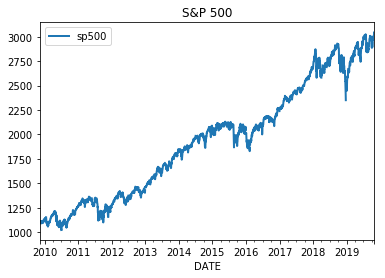

In [45]:
#plotting
sp500D.plot(lw=2)
sp500plt = plt.title('S&P 500')

In [46]:
## collapse to monthly data 
sp500D.index = pd.to_datetime(sp500D.index)
sp500M = sp500D.resample('M').last()

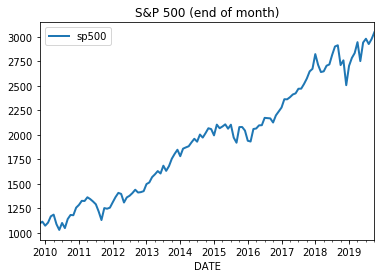

In [47]:
sp500M.plot(lw=2)
sp500Mplt = plt.title('S&P 500 (end of month)')

In [48]:
sp500MR = np.log(sp500M).diff()

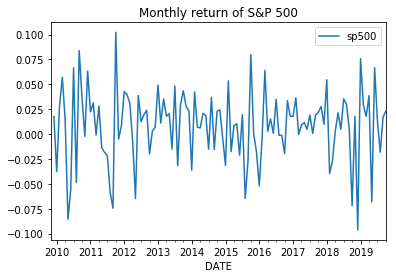

In [49]:
sp500MR.plot()
sp500MRplt = plt.title('Monthly return of S&P 500')

###  2. Loading and cleaning perceived income series 

In [50]:
## loading the stata file
SCEProbIndM = pd.read_stata('../SurveyData/SCE/IncExpSCEProbIndM.dta')
SCEDstIndM = pd.read_stata('../SurveyData/SCE/IncExpSCEDstIndM.dta')

In [51]:
## subselect the dataframe
sub_var = ['date','userid','Q24_var','Q24_mean','Q24_iqr']
IncSCEIndMoms = SCEProbIndM[sub_var]
sub_var2 = ['date','userid','IncVar','IncMean','IncSkew','IncKurt']
IncSCEIndMomsEst = SCEDstIndM[sub_var2]

## drop nan observations
IncSCEIndMoms = IncSCEIndMoms.dropna(how='any')
IncSCEIndMomsEst = IncSCEIndMomsEst.dropna(how='any')


In [52]:
## deal with clusterring skewness value around zero first

IncSCEIndMomsEst['IncSkew'] = IncSCEIndMomsEst['IncSkew'].copy().replace(0,np.nan)

In [53]:
moms = ['Q24_mean','Q24_var','Q24_iqr']
moms_est = ['IncVar','IncMean','IncSkew','IncKurt']

## compute population summary stats for these ind moms
IncSCEPopMomsMed = pd.pivot_table(data = IncSCEIndMoms, 
                                  index=['date'], 
                                  values = moms,
                                  aggfunc= 'median').reset_index().rename(columns={'Q24_mean': 'meanMed', 
                                                                                   'Q24_var': 'varMed',
                                                                                  'Q24_iqr': 'iqrMed'})

IncSCEPopMomsMean = pd.pivot_table(data = IncSCEIndMoms, 
                                   index=['date'], 
                                  values = moms,
                                  aggfunc= 'mean').reset_index().rename(columns={'Q24_mean': 'meanMean',
                                                                                 'Q24_var': 'varMean',
                                                                                 'Q24_iqr': 'iqrMean'})

IncSCEPopMomsEstMed = pd.pivot_table(data = IncSCEIndMomsEst, 
                                     index=['date'],
                                     values = moms_est,
                                     aggfunc= 'median').reset_index().rename(columns={'IncMean': 'meanEstMed',
                                                                                      'IncVar': 'varEstMed',
                                                                                      'IncSkew': 'skewEstMed',
                                                                                      'IncKurt':'kurtEstMed'})

IncSCEPopMomsEstMean = pd.pivot_table(data = IncSCEIndMomsEst, 
                                      index=['date'],
                                      values = moms_est,
                                      aggfunc= 'mean').reset_index().rename(columns={'IncMean': 'meanEstMean',
                                                                                    'IncVar': 'varEstMean',
                                                                                    'IncSkew': 'skewEstMean',
                                                                                    'IncKurt':'kurtEstMean'})

In [54]:
## streamline the dates for merging 

# adjusting the end-of-month dates to the begining-of-month for combining 
sp500MR.index = sp500MR.index.shift(1,freq='D') 

IncSCEPopMomsMed.index = pd.DatetimeIndex(IncSCEPopMomsMed['date'] ,freq='infer')
IncSCEPopMomsMean.index = pd.DatetimeIndex(IncSCEPopMomsMean['date'] ,freq='infer')
IncSCEPopMomsEstMed.index = pd.DatetimeIndex(IncSCEPopMomsEstMed['date'] ,freq='infer')
IncSCEPopMomsEstMean.index = pd.DatetimeIndex(IncSCEPopMomsEstMean['date'] ,freq='infer')

### 3. Combinine the two series 

In [55]:
dt_combM = pd.concat([sp500MR,
                      IncSCEPopMomsMed,
                      IncSCEPopMomsMean,
                      IncSCEPopMomsEstMed,
                      IncSCEPopMomsEstMean],
                     join="inner",axis=1).drop(columns=['date'])

In [56]:
dt_combM.tail()

,sp500,iqrMed,meanMed,varMed,iqrMean,meanMean,varMean,kurtEstMed,meanEstMed,skewEstMed,varEstMed,kurtEstMean,meanEstMean,skewEstMean,varEstMean
2018-01-01,0.01,1.30,2.73,0.88,2.21,2.98,4.04,-0.60,1.00,0.19,0.33,-0.45,1.88,0.10,0.49
2018-02-01,0.05,1.17,2.83,0.70,2.25,3.08,4.23,-0.60,1.00,0.16,0.33,-0.51,1.84,0.12,0.48
2018-03-01,-0.04,1.17,2.70,0.67,2.12,2.95,3.81,-0.60,1.00,0.18,0.33,-0.51,1.92,0.14,0.49
2018-04-01,-0.03,1.17,2.83,0.71,2.07,3.05,3.42,-0.60,1.00,0.20,0.33,-0.46,1.81,0.17,0.46
2018-05-01,0.00,1.17,2.83,0.71,2.19,3.08,3.86,-0.60,1.00,0.20,0.33,-0.47,1.74,0.16,0.45


In [57]:
dt_combM.corr()

,sp500,iqrMed,meanMed,varMed,iqrMean,meanMean,varMean,kurtEstMed,meanEstMed,skewEstMed,varEstMed,kurtEstMean,meanEstMean,skewEstMean,varEstMean
sp500,1.00,0.03,0.07,0.04,0.21,0.02,0.24,-0.00,0.01,-0.03,0.00,-0.00,-0.13,-0.02,-0.12
iqrMed,0.03,1.00,0.54,0.98,0.68,0.62,0.55,-0.00,-0.15,0.37,-0.00,-0.09,0.07,0.13,-0.13
meanMed,0.07,0.54,1.00,0.58,0.56,0.89,0.49,-0.00,-0.02,0.60,-0.00,-0.21,0.49,0.24,0.29
varMed,0.04,0.98,0.58,1.00,0.71,0.65,0.57,-0.00,-0.15,0.40,-0.00,-0.09,0.08,0.15,-0.12
iqrMean,0.21,0.68,0.56,0.71,1.00,0.67,0.95,-0.00,-0.20,0.32,-0.00,-0.21,0.02,0.11,-0.08
meanMean,0.02,0.62,0.89,0.65,0.67,1.00,0.55,0.00,-0.03,0.60,0.00,-0.21,0.43,0.26,0.24
varMean,0.24,0.55,0.49,0.57,0.95,0.55,1.00,-0.00,-0.18,0.22,-0.00,-0.21,0.02,0.04,-0.04
kurtEstMed,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,1.00,0.00,0.00,1.00,-0.00,0.00,0.00,0.00
meanEstMed,0.01,-0.15,-0.02,-0.15,-0.20,-0.03,-0.18,0.00,1.00,0.19,0.00,0.10,0.24,0.15,0.20
skewEstMed,-0.03,0.37,0.60,0.40,0.32,0.60,0.22,0.00,0.19,1.00,0.00,-0.01,0.36,0.71,0.25


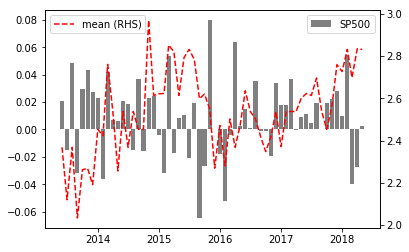

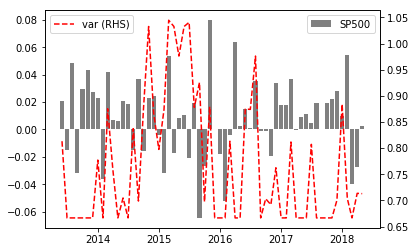

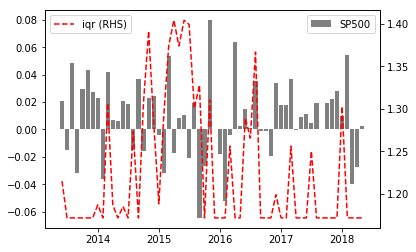

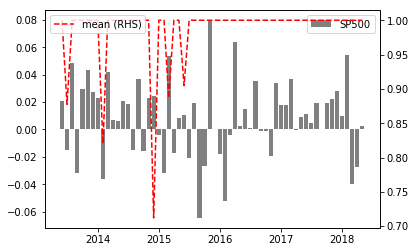

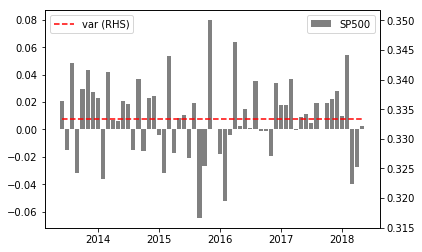

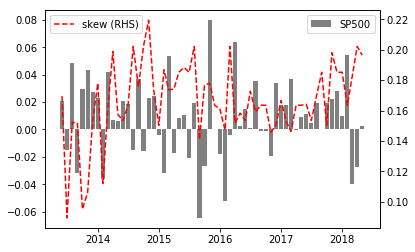

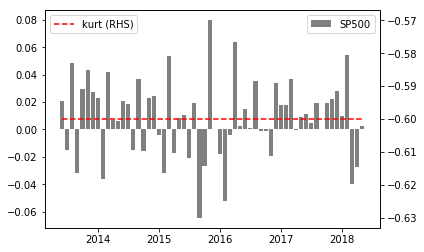

In [58]:
## plots of correlation for MEDIAN population stats 

for i,moms in enumerate( ['mean','var','iqr']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(dt_combM.index, dt_combM['sp500'], color='gray', width=25,label='SP500')
    ax2.plot(dt_combM[str(moms)+'Med'], 'r--',label=str(moms)+' (RHS)')
    #ax.set_xticklabels(dt_combM.index)
    ax.legend(loc=0)
    ax2.legend(loc=2)
    
for i,moms in enumerate( ['mean','var','skew','kurt']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(dt_combM.index, dt_combM['sp500'], color='gray', width=25,label='SP500')
    ax2.plot(dt_combM[str(moms)+'EstMed'], 'r--',label=str(moms)+' (RHS)')
    #ax.set_xticklabels(dt_combM.index)
    ax.legend(loc=0)
    ax2.legend(loc=2)

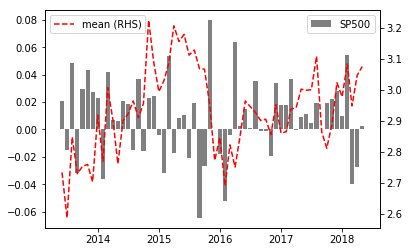

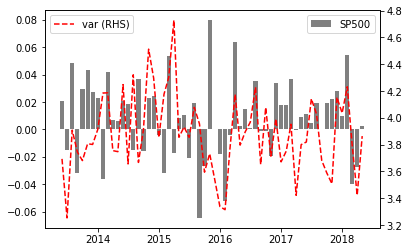

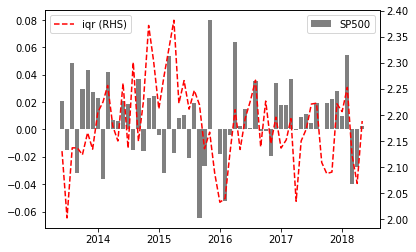

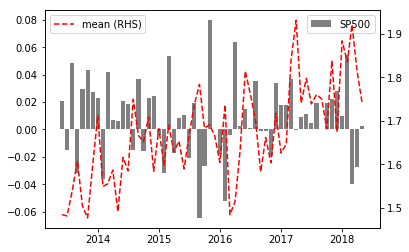

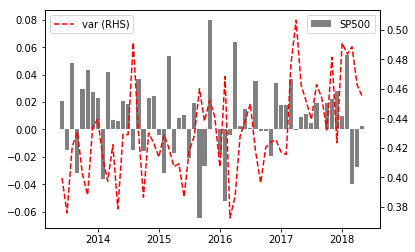

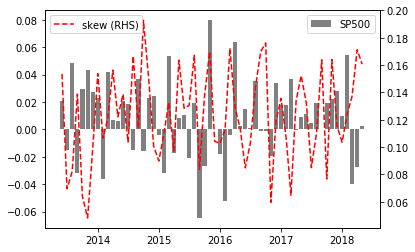

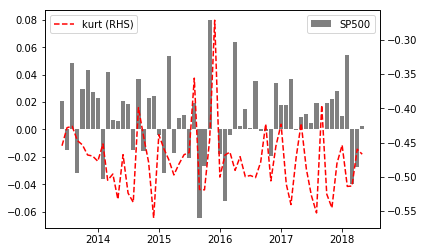

In [59]:
## plots of correlation for Mean population stats 

for i,moms in enumerate( ['mean','var','iqr']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(dt_combM.index, dt_combM['sp500'], color='gray', width=25,label='SP500')
    ax2.plot(dt_combM[str(moms)+'Mean'], 'r--',label=str(moms)+' (RHS)')
    #ax.set_xticklabels(dt_combM.index)
    ax.legend(loc=0)
    ax2.legend(loc=2)
    
for i,moms in enumerate( ['mean','var','skew','kurt']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(dt_combM.index, dt_combM['sp500'], color='gray', width=25,label='SP500')
    ax2.plot(dt_combM[str(moms)+'EstMean'], 'r--',label=str(moms)+' (RHS)')
    #ax.set_xticklabels(dt_combM.index)
    ax.legend(loc=0)
    ax2.legend(loc=2)

In [60]:
## moving average 

dt_combM3mv = dt_combM.rolling(4).mean()

In [61]:
dt_combM3mv.corr()

,sp500,iqrMed,meanMed,varMed,iqrMean,meanMean,varMean,kurtEstMed,meanEstMed,skewEstMed,varEstMed,kurtEstMean,meanEstMean,skewEstMean,varEstMean
sp500,1.00,-0.36,-0.25,-0.35,-0.05,-0.30,0.07,0.00,0.06,-0.30,nan,-0.39,-0.01,-0.37,0.08
iqrMed,-0.36,1.00,0.62,0.99,0.77,0.78,0.63,0.00,-0.45,0.54,nan,0.10,-0.01,0.32,-0.30
meanMed,-0.25,0.62,1.00,0.64,0.60,0.92,0.57,-0.00,-0.23,0.81,nan,-0.34,0.63,0.48,0.39
varMed,-0.35,0.99,0.64,1.00,0.81,0.78,0.68,-0.00,-0.50,0.55,nan,0.07,-0.02,0.32,-0.31
iqrMean,-0.05,0.77,0.60,0.81,1.00,0.73,0.96,-0.00,-0.57,0.50,nan,-0.29,-0.04,0.28,-0.27
meanMean,-0.30,0.78,0.92,0.78,0.73,1.00,0.64,-0.00,-0.30,0.75,nan,-0.19,0.49,0.46,0.23
varMean,0.07,0.63,0.57,0.68,0.96,0.64,1.00,0.00,-0.54,0.42,nan,-0.43,-0.01,0.20,-0.21
kurtEstMed,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,1.00,0.00,-0.00,nan,0.00,0.00,0.00,-0.00
meanEstMed,0.06,-0.45,-0.23,-0.50,-0.57,-0.30,-0.54,0.00,1.00,-0.13,nan,-0.04,0.32,0.06,0.41
skewEstMed,-0.30,0.54,0.81,0.55,0.50,0.75,0.42,-0.00,-0.13,1.00,nan,-0.25,0.47,0.77,0.28


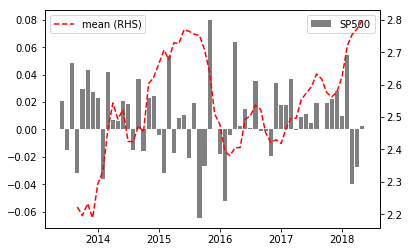

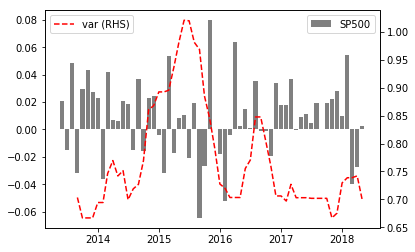

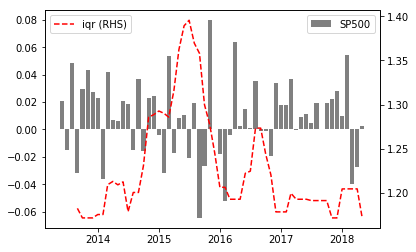

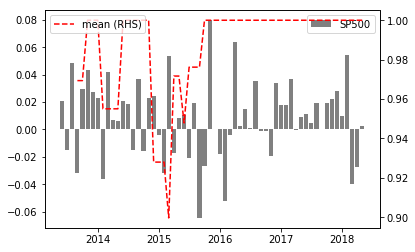

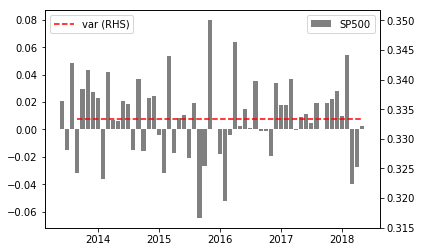

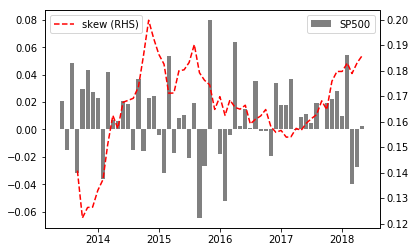

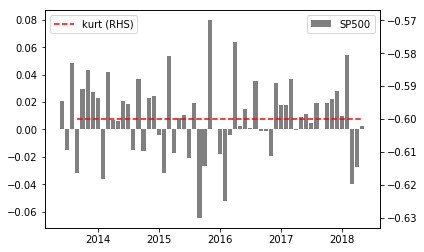

In [62]:
## plots of correlation for 3-month moving MEDIAN average 

for i,moms in enumerate( ['mean','var','iqr']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(dt_combM3mv.index, dt_combM['sp500'], color='gray', width=25,label='SP500')
    ax2.plot(dt_combM3mv[str(moms)+'Med'], 'r--',label=str(moms)+' (RHS)')
    #ax.set_xticklabels(dt_combM.index)
    ax.legend(loc=0)
    ax2.legend(loc=2)
    

for i,moms in enumerate( ['mean','var','skew','kurt']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(dt_combM3mv.index, dt_combM['sp500'], color='gray', width=25,label='SP500')
    ax2.plot(dt_combM3mv[str(moms)+'EstMed'], 'r--',label=str(moms)+' (RHS)')
    #ax.set_xticklabels(dt_combM.index)
    ax.legend(loc=0)
    ax2.legend(loc=2)

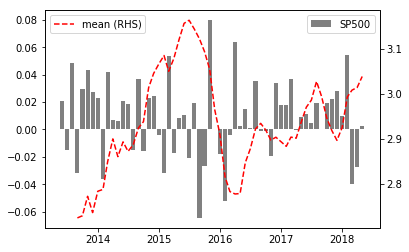

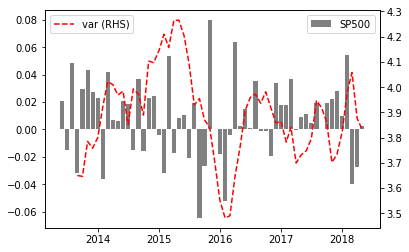

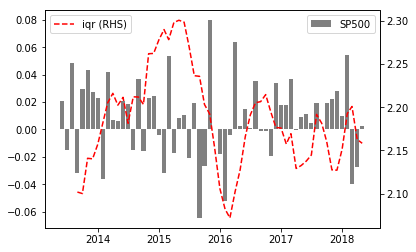

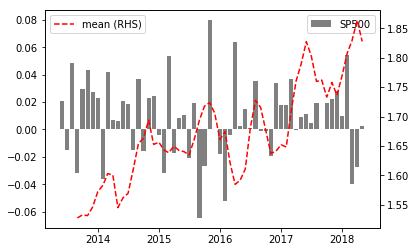

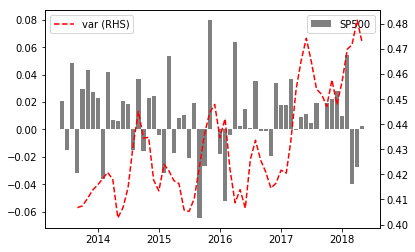

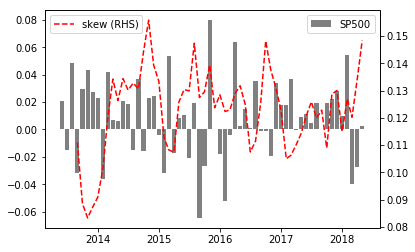

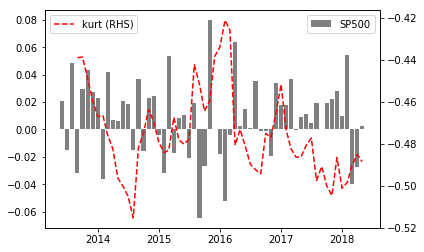

In [63]:
## plots of correlation for 3-month moving mean average 

for i,moms in enumerate( ['mean','var','iqr']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(dt_combM3mv.index, dt_combM['sp500'], color='gray', width=25,label='SP500')
    ax2.plot(dt_combM3mv[str(moms)+'Mean'], 'r--',label=str(moms)+' (RHS)')
    #ax.set_xticklabels(dt_combM.index)
    ax.legend(loc=0)
    ax2.legend(loc=2)
    
for i,moms in enumerate( ['mean','var','skew','kurt']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(dt_combM3mv.index, dt_combM['sp500'], color='gray', width=25,label='SP500')
    ax2.plot(dt_combM3mv[str(moms)+'EstMean'], 'r--',label=str(moms)+' (RHS)')
    #ax.set_xticklabels(dt_combM.index)
    ax.legend(loc=0)
    ax2.legend(loc=2)